In [38]:
#import libraries
import warnings
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os, glob


In [39]:
#load data from csv
df=pd.read_csv("data/gicsd_labels.csv")

In [42]:
df.head()

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY


In [44]:
df.isnull().any()#checking null values

IMAGE_FILENAME    False
 LABEL            False
dtype: bool

#### data doesn't have any null values

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IMAGE_FILENAME  800 non-null    object
 1    LABEL          800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


#### data has 800 rows and 2 columns as 'IMAGE_FILENAME' and ' LABEL'

In [46]:
df.columns

Index(['IMAGE_FILENAME', ' LABEL'], dtype='object')

#### we have spaces in label "LABEL" . There may be other spaces. we can to remove space from name by strip function.

In [47]:
# rm whitespace from col name
df = df.rename(columns={' LABEL': 'LABEL'})

In [48]:
# strip whitespace of all values in df
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#### Checking for unique values

In [49]:
df['IMAGE_FILENAME'].is_unique

True

In [17]:
#### we have unique image file name  in our dataset

<AxesSubplot:xlabel='LABEL', ylabel='count'>

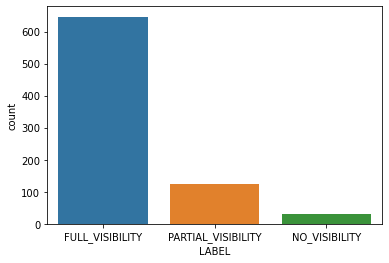

In [50]:
sns.countplot(df['LABEL'])

In [51]:
df['LABEL'].value_counts()

FULL_VISIBILITY       646
PARTIAL_VISIBILITY    123
NO_VISIBILITY          31
Name: LABEL, dtype: int64

#### We have 646 samples of FULL_VISIBILITY, 123 samples of PARTIAL_VISIBILITY and 31 samples from NO_VISIBILITY

In [12]:
from PIL import Image
from pylab import *


#### Data preprocessing
     As we know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as we know, neural networks prefer to deal with small input values).

In [52]:
def get_files(filepath, extension):
    
    """get list of all files within a directory"""
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.{}'.format(extension)))
        for f in files :
            all_files.append(os.path.abspath(f))
    return all_files

def get_filenames(filepaths):
    
    """get list of filenames from a list of filepaths"""
    filenames = list()
    for path in filepaths:
        name = os.path.basename(path)
        filenames.append(name)
    return filenames

def check_lists_equal(list1, list2):
    """check if two unordered lists are equal; same elements, same length"""
    if set(list1) == set(list2):
        return True
    else:
        return False
def match_filename_to_filepath(filenames_list, paths_list):
    import os
    """returns list of ordered paths to corresponding to filenames list input"""
    ordered_paths = []
    for filename in filenames_list:
        for path in paths_list:
            subdir = os.path.dirname(path)
            name = os.path.basename(path)
            if filename == name:
                ordered_paths.append(
                    os.path.join(subdir,name))
    return ordered_paths

In [53]:
# generate list of filenames & preview
filenames_list = list(df.IMAGE_FILENAME)
filenames_list[0:5]

['GICSD_1_0_3.png',
 'GICSD_1_0_13.png',
 'GICSD_1_1_33.png',
 'GICSD_1_1_53.png',
 'GICSD_1_2_73.png']

float32
(192, 192, 3)


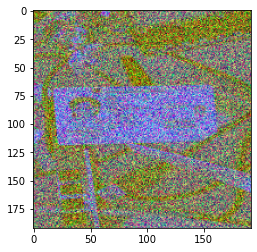

In [54]:
# # load and show an image with Pillow

from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
image = image.imread('./data/images/GICSD_1_0_3.png')
# summarize shape of the pixel array
print(image.dtype)
print(image.shape)
# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()

In [ ]:
# image = Image.open('./data/images/GICSD_1_0_3.png')
# bg = Image.new('RGBA',image.size,(255,255,255))
# bg.paste(image,(0,0),image)
# bg.save("test.jpg", quality=95)
# pyplot.imshow(image)
# pyplot.show()

In [55]:

# generate list of filepaths & preview
paths_list = get_files('./data/images/','png')

In [56]:
# check that data.IMAGE_FILENAME matches all image filenames in folder    
check_lists_equal(
    get_filenames(paths_list), 
    list(df['IMAGE_FILENAME'])
)

True

In [63]:
# get list of paths corresponding to data.IMAGE_FILENAME
ordered_paths = match_filename_to_filepath(filenames_list, paths_list)

In [64]:
# Add filepaths to df
df['FILEPATH'] = pd.Series(ordered_paths)

In [65]:
df.head()

,IMAGE_FILENAME,LABEL,FILEPATH,WIDTH,HEIGHT
0,GICSD_1_0_3.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
1,GICSD_1_0_13.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
3,GICSD_1_1_53.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
4,GICSD_1_2_73.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192


In [66]:

# check image size !!!!
from PIL import Image
def check_image_size(image_path):
    img = Image.open(image_path)
    width, height = img.size
    return width, height

def add_img_sizes(df, filepaths):
    img_width = list()
    img_height = list()
    for path in filepaths:
        width, height = check_image_size(path)
        img_width.append(width)
        img_height.append(height)
    df['WIDTH'] = pd.Series(img_width)
    df['HEIGHT'] = pd.Series(img_height)

In [67]:
add_img_sizes(df, ordered_paths)
df.head()

,IMAGE_FILENAME,LABEL,FILEPATH,WIDTH,HEIGHT
0,GICSD_1_0_3.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
1,GICSD_1_0_13.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
3,GICSD_1_1_53.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192
4,GICSD_1_2_73.png,FULL_VISIBILITY,C:\Users\mukesh\mystuff\Challenge - ML Enginee...,192,192


In [68]:
def split_image_dataset(df, visibility, dst_path):
    from shutil import copyfile
    import os
    """create directory of images with different labelled visibilities 
    and copy corresponding images to folder"""
    # split df into category of visibility 
    df = df.loc[df['LABEL'] == visibility]
    
    if not os.path.exists(dst_path):
        #create new dst folder
        os.mkdir(dst_path)
        count = 0
        for index, row in df.iterrows():
            src = df.FILEPATH[index]
            out_filename = df.IMAGE_FILENAME[index]
            dst = '{}/{}'.format(dst_path, out_filename)
            copyfile(src, dst)
            count+=1
        print('Success! Copied {} files to {}'.format(count, dst_path))
    else:
        print('dst_path already exists! Skipping!')

In [62]:
# Split into 3 df categories of Image visibilities
split_image_dataset(df, 'FULL_VISIBILITY', './data/new_images/full_visibility')
split_image_dataset(df, 'PARTIAL_VISIBILITY', './data/new_images/partial_visibility')
split_image_dataset(df, 'NO_VISIBILITY', './data/new_images/no_visibility')

dst_path already exists! Skipping!
dst_path already exists! Skipping!
dst_path already exists! Skipping!


#### Each parameter (red, green, and blue) defines the intensity of the color as an int between 0 to 255.

(255,0,0) == red
(0,255,0) == green
(0,0,255) == blue
All colors are made up of specific ratios of R:G:B.

Each pixel in the image is converted to it's specific RGB color tuple in the np.array thus shape is 192 x 192 x 3

#### Loading images from the dataset

In [69]:
from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)  
# train_generator = train_datagen.flow_from_directory(
# train_dir,
# target_size=(150, 150)
# batch_size=20,
# class_mode='binary')

train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='./data/new_images',
                                                 shuffle=True,
                                                 target_size=(192, 192), 
                                                 subset="training",
                                                 class_mode='categorical')

test_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='./data/new_images',
                                                 shuffle=True,
                                                 target_size=(192, 192), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 641 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


#### Building the CNN

In [70]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(192, 192, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 20, 128)      

In [72]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy'])

#### Training the Model

In [73]:
history = model.fit_generator(
train_dataset,
steps_per_epoch=100,
epochs=10,
validation_data=test_dataset,
validation_steps=50)

Epoch 1/10
100/100 [==============================] - 360s 4s/step - loss: 0.5937 - categorical_accuracy: 0.8049 - val_loss: 0.4373 - val_categorical_accuracy: 0.8176
Epoch 2/10
100/100 [==============================] - 401s 4s/step - loss: 0.4422 - categorical_accuracy: 0.8306 - val_loss: 0.5869 - val_categorical_accuracy: 0.7484
Epoch 3/10
100/100 [==============================] - 403s 4s/step - loss: 0.3937 - categorical_accuracy: 0.8545 - val_loss: 0.2775 - val_categorical_accuracy: 0.7925
Epoch 4/10
100/100 [==============================] - 431s 4s/step - loss: 0.2836 - categorical_accuracy: 0.8867 - val_loss: 0.5259 - val_categorical_accuracy: 0.8050
Epoch 5/10
100/100 [==============================] - 447s 4s/step - loss: 0.2071 - categorical_accuracy: 0.9248 - val_loss: 0.5978 - val_categorical_accuracy: 0.7799
Epoch 6/10
100/100 [==============================] - 434s 4s/step - loss: 0.1336 - categorical_accuracy: 0.9461 - val_loss: 0.6291 - val_categorical_accuracy: 0.798

#### Saving the Model

In [74]:
model.save('basemodel.h5')

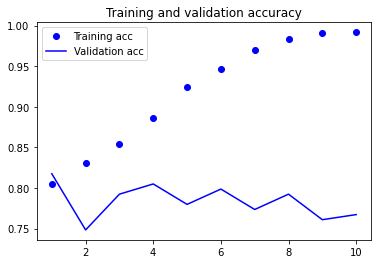

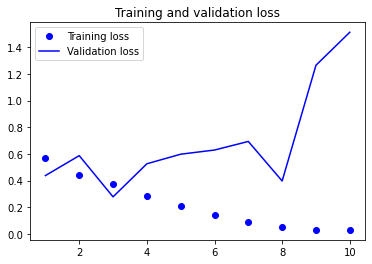

In [75]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()